<a href="https://colab.research.google.com/github/RickPardono/cdProjetoAplicadoIV/blob/main/Notebook_do_Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar bibliotecas necessárias
!pip install tensorflow==2.17.0
!pip install pmdarima

In [ ]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GaussianNoise, BatchNormalization
from tensorflow.keras.optimizers import Adam
from pmdarima import auto_arima
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import random

In [ ]:
# Definir a seed para resultados consistentes
#SEED = random.randint(0, 2**32 - 1)

SEED = 2288652641
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Carregar os dados
url = 'https://github.com/RickPardono/cdProjetoAplicadoIV/blob/main/Dados_abertos_Consumo_Mensal.xlsx?raw=true'
df = pd.read_excel(url)

In [ ]:
df.head()

,Data,DataExcel,Regiao,Sistema,Classe,TipoConsumidor,Consumo,Consumidores
0,20240601,2024-06-01,Centro-Oeste,SUDESTE / CENTRO - OESTE,Comercial,Cativo,448252.309,503876.0
1,20240601,2024-06-01,Centro-Oeste,SUDESTE / CENTRO - OESTE,Comercial,Livre,200313.573,2075.0
2,20240601,2024-06-01,Centro-Oeste,SUDESTE / CENTRO - OESTE,Industrial,Cativo,81441.302,31757.0
3,20240601,2024-06-01,Centro-Oeste,SUDESTE / CENTRO - OESTE,Industrial,Livre,884213.886,899.0
4,20240601,2024-06-01,Centro-Oeste,SUDESTE / CENTRO - OESTE,Outros,Cativo,359051.301,63248.0


In [ ]:
df.shape

(16661, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16661 entries, 0 to 16660
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Data            16661 non-null  int64         
 1   DataExcel       16661 non-null  datetime64[ns]
 2   Regiao          16661 non-null  object        
 3   Sistema         16661 non-null  object        
 4   Classe          16661 non-null  object        
 5   TipoConsumidor  16661 non-null  object        
 6   Consumo         16661 non-null  float64       
 7   Consumidores    16661 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
# Pré-processamento
# Agrupando por mês e somando o consumo de todas as Regiões, Sistemas, Classe e Tipo de Consumidor:
df_agg = df.groupby(df['DataExcel'])['Consumo'].sum().reset_index()
df_agg.rename(columns={'DataExcel': 'Mes'}, inplace=True)
df_agg['Consumo'] = (df_agg['Consumo'] / 1000).round(2)  # Converter de MWh para GWh
df_agg['Ano'] = df_agg['Mes'].dt.year # Adicionar uma coluna 'Ano'
dados_serie = df_agg[['Mes', 'Consumo']].set_index('Mes')

y = dados_serie['Consumo'].values  # Transformar a série temporal em array para comparar tamanhos
# Verificar e ajustar tamanho dos dados
if len(dados_serie) != len(y):
    dados_serie = dados_serie.iloc[-len(y):]  # Alinhar os tamanhos

In [ ]:
df_agg.head()

,Mes,Consumo,Ano
0,2004-01-01,26978.36,2004
1,2004-02-01,26508.27,2004
2,2004-03-01,27284.34,2004
3,2004-04-01,28046.18,2004
4,2004-05-01,27248.16,2004


In [ ]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Mes      246 non-null    datetime64[ns]
 1   Consumo  246 non-null    float64       
 2   Ano      246 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 4.9 KB


In [ ]:
df_agg['Mes'].min()

Timestamp('2004-01-01 00:00:00')

In [ ]:
df_agg['Mes'].max()

Timestamp('2024-06-01 00:00:00')

In [ ]:
df_agg.head()

,Mes,Consumo,Ano
0,2004-01-01,26978.36,2004
1,2004-02-01,26508.27,2004
2,2004-03-01,27284.34,2004
3,2004-04-01,28046.18,2004
4,2004-05-01,27248.16,2004


In [ ]:
df_agg.shape

(246, 3)

In [ ]:
dados_serie.head()

,Consumo
Mes,
2004-01-01,26978.36
2004-02-01,26508.27
2004-03-01,27284.34
2004-04-01,28046.18
2004-05-01,27248.16


In [ ]:
dados_serie.describe()

,Consumo
count,246.000000
mean,36882.081423
std,5013.990933
min,26508.270000
25%,32301.202500
50%,37998.645000
75%,40411.182500
max,47837.270000


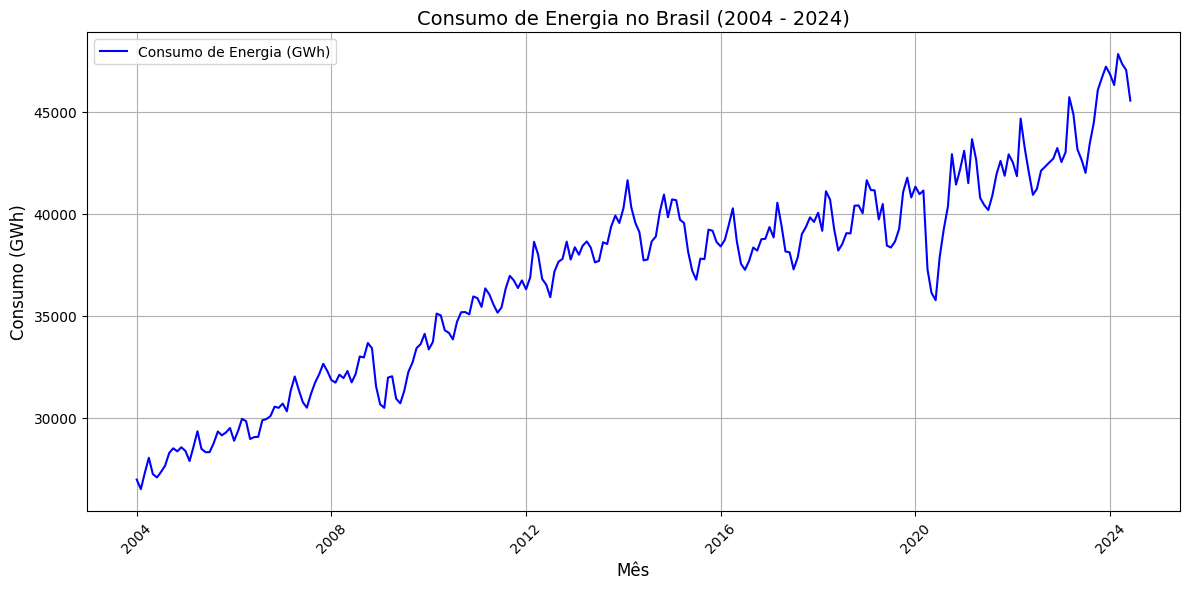

In [ ]:
# Plotar gráfico de linha para identificar tendências, sazonalidade e ciclos
plt.figure(figsize=(12, 6))
plt.plot(dados_serie.index, dados_serie['Consumo'], label='Consumo de Energia (GWh)', color='b')
plt.title('Consumo de Energia no Brasil (2004 - 2024)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Consumo (GWh)', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O gráfico de linha mostra claramente um padrão de tendência crescente ao longo do tempo, com flutuações sazonais visíveis. Isso sugere que há uma tendência de aumento no consumo de energia ao longo dos anos.
Há também oscilações regulares, indicando sazonalidade no consumo de energia, o que é típico em séries temporais de consumo de energia elétrica.

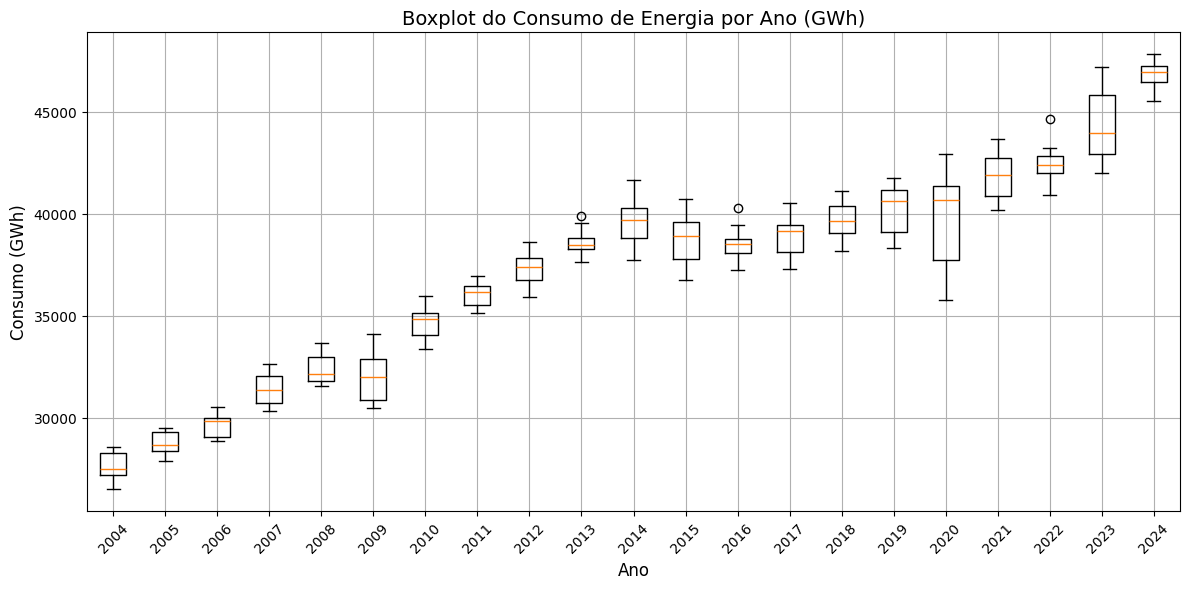

In [ ]:
# Agrupar os dados por ano para fazer o boxplot
data_por_ano = [df_agg[df_agg['Ano'] == ano]['Consumo'].values for ano in df_agg['Ano'].unique()]

# Criar o boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(data_por_ano, labels=df_agg['Ano'].unique())
plt.title('Boxplot do Consumo de Energia por Ano (GWh)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Consumo (GWh)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O boxplot indica outliers em alguns anos, como 2013, 2016 e 2022. Esses outliers podem indicar eventos anômalos, como variações extremas no consumo de energia (possivelmente causadas por condições climáticas, mudanças econômicas ou eventos extraordinários).
As caixas também mostram o aumento gradual do consumo de energia ano após ano.

In [ ]:
# Função para calcular o IQR e identificar os outliers para cada ano
def identificar_outliers_por_ano(df, ano):
    df_ano = df[df['Ano'] == ano]

    # Calcular os quartis e o intervalo interquartil (IQR) para o ano específico
    Q1 = df_ano['Consumo'].quantile(0.25)
    Q3 = df_ano['Consumo'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir limites de outliers para o ano específico
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar os outliers para o ano específico
    outliers_ano = df_ano[(df_ano['Consumo'] < limite_inferior) | (df_ano['Consumo'] > limite_superior)]

    return outliers_ano

# Aplicar a função para os anos 2013, 2016 e 2022
outliers_2013 = identificar_outliers_por_ano(df_agg, 2013)
outliers_2016 = identificar_outliers_por_ano(df_agg, 2016)
outliers_2022 = identificar_outliers_por_ano(df_agg, 2022)

# Exibir os outliers de cada ano
print("Outliers de 2013:")
print(outliers_2013)

print("\nOutliers de 2016:")
print(outliers_2016)

print("\nOutliers de 2022:")
print(outliers_2022)

Outliers de 2013:
           Mes   Consumo   Ano
118 2013-11-01  39920.29  2013

Outliers de 2016:
           Mes   Consumo   Ano
147 2016-04-01  40276.23  2016

Outliers de 2022:
           Mes   Consumo   Ano
218 2022-03-01  44674.11  2022


Os meses que identificaram outliers (novembro de 2013, abril de 2016 e março de 2022) coincidem com períodos em que ocorreram eventos importantes no setor energético e climático no Brasil:

Março de 2022: Este período foi marcado por desafios no setor energético devido a crises hídricas que impactaram a capacidade das usinas hidrelétricas no Brasil. Isso levou ao aumento do uso de usinas térmicas, elevando o consumo de energia e os custos. A crise hídrica de 2021 ainda estava sendo sentida no início de 2022, o que pode explicar o aumento significativo no consumo em março de 2022​.

Abril de 2016: O Brasil estava enfrentando uma combinação de fatores, incluindo variações sazonais e mudanças climáticas que afetaram o regime de chuvas, além de questões econômicas que impactaram a demanda energética. Embora 2016 não tenha sido marcado por uma crise hídrica tão severa quanto 2022, as flutuações no fornecimento de energia e nas condições climáticas podem ter contribuído para o aumento do consumo em abril de 2016.

Novembro de 2013: Durante este período, o Brasil começou a lidar com uma série de mudanças nas políticas energéticas, incluindo a expansão da geração de energia por fontes renováveis, como solar e eólica. Esses movimentos, juntamente com variações sazonais, podem ter impactado o padrão de consumo energético​.

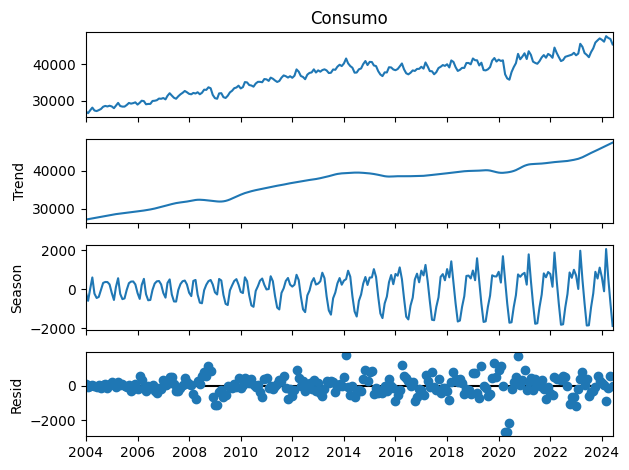

In [ ]:
# decompor a série temporal utilizando o método STL (Seasonal and Trend decomposition using Loess).
# Isso nos permitirá visualizar claramente a tendência, a sazonalidade e o componente residual (ruído) da série.
stl = STL(dados_serie['Consumo'], seasonal=13)
resultado_stl = stl.fit()
# Plotar a decomposição
fig = resultado_stl.plot()
plt.show()

Decomposição da Série Temporal (STL): Tendência (Trend): A linha de tendência mostra um crescimento constante ao longo do tempo, com um aumento significativo próximo ao final da série, especialmente após 2020. Isso indica uma elevação no consumo de energia elétrica ao longo do período analisado. Sazonalidade (Season): O componente sazonal é visível, com flutuações regulares que parecem ter um padrão repetitivo ao longo dos anos, indicando uma sazonalidade clara, que se repete a cada ano. Os resíduos estão dispersos ao redor da linha central (zero) e parecem aleatórios.

In [ ]:
# Testes de estacionariedade (ADF e KPSS)

# Utilizar a tendência da decomposição STL para aplicar os testes de estacionariedade
tendencia_stl = resultado_stl.trend.dropna()  # Remover valores nulos da tendência para os testes

# Teste ADF na tendência extraída
resultado_adf = adfuller(tendencia_stl)
print("Teste ADF")
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:", resultado_adf[4])
if resultado_adf[1] <= 0.05:
    print("A série (tendência) é estacionária (p-value <= 0.05).")
else:
    print("A série (tendência) não é estacionária (p-value > 0.05).")

# Teste KPSS na tendência extraída
resultado_kpss, p_value, _, critical_values = kpss(tendencia_stl, regression='c')
print("\nTeste KPSS")
print("KPSS Statistic:", resultado_kpss)
print("p-value:", p_value)
print("Critical Values:", critical_values)
if p_value > 0.05:
    print("A série (tendência) é estacionária (p-value > 0.05).")
else:
    print("A série (tendência) não é estacionária (p-value <= 0.05).")

# Separar a série em treino e teste para o Auto-Sarima (70% treino, 30% teste)
tamanho_treino = int(len(dados_serie) * 0.7)
treino, teste = dados_serie[:tamanho_treino], dados_serie[tamanho_treino:]

# Ajuste do modelo AutoSARIMA no conjunto de treino
modelo_auto_sarima = auto_arima(
    treino,
    seasonal=True,
    m=12,  # período sazonal, ajustado conforme o padrão mensal
    trace=True,  # Mostra o progresso e a escolha dos parâmetros
    suppress_warnings=True,
    stepwise=True  # Otimização mais rápida com busca sequencial
)

# Fazer previsões para o conjunto de teste
previsoes_teste = modelo_auto_sarima.predict(n_periods=len(teste))

# Converter previsões para série com índice de teste
previsoes_teste = pd.Series(previsoes_teste, index=teste.index)

# Cálculo das métricas de erro
rmse = np.sqrt(mean_squared_error(teste, previsoes_teste))  # Corrigido para calcular RMSE
mse = mean_squared_error(teste, previsoes_teste)  # MSE
mape = mean_absolute_percentage_error(teste, previsoes_teste)  # MAPE

# Exibir as métricas
print("RMSE AutoSARIMA:", rmse)
print("MSE AutoSARIMA:", mse)
print("MAPE AutoSARIMA:", mape)

Teste ADF
ADF Statistic: 0.27172989664401936
p-value: 0.9760096392409648
Critical Values: {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}
A série (tendência) não é estacionária (p-value > 0.05).

Teste KPSS
KPSS Statistic: 2.188464844604355
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
A série (tendência) não é estacionária (p-value <= 0.05).
Performing stepwise search to minimize aic


<ipython-input-74-f6e489325556>:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado_kpss, p_value, _, critical_values = kpss(tendencia_stl, regression='c')


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2729.110, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2708.048, Time=3.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2712.094, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2729.353, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2731.021, Time=0.12 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2708.494, Time=3.39 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2705.608, Time=6.31 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2712.124, Time=4.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2703.195, Time=2.03 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2710.819, Time=0.82 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2702.122, Time=2.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2709.307, Time=2.39 sec
 ARIMA(0,1

**Ajuste e Avaliação do Modelo Auto-SARIMA**

Neste trecho, realizamos uma análise aprofundada da série temporal antes de ajustar o modelo Auto-SARIMA, utilizando dois testes de estacionariedade: o teste ADF (Dickey-Fuller Aumentado) e o teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin), aplicados à tendência extraída da decomposição STL.

**Testes de Estacionariedade**

A estacionariedade é uma condição fundamental para modelos como o SARIMA, que pressupõem que os padrões estatísticos da série (média, variância) não mudem ao longo do tempo.

**ADF:** Avalia a presença de raiz unitária. Um p-valor menor que 0.05 indica que a série é estacionária.

**KPSS**: Verifica se a série é estacionária em torno de uma média constante. Aqui, um p-valor maior que 0.05 indica estacionariedade.

Com base nos resultados:

O ADF indicou que a série não é estacionária, com p-valor maior que 0.05.

O KPSS confirmou a não estacionariedade, com p-valor menor que 0.05.

**Ajuste do Auto-SARIMA**

Após os testes, ajustamos o modelo Auto-SARIMA, que identifica automaticamente os melhores parâmetros para o modelo SARIMA com base em critérios de informação (AIC). O período sazonal foi configurado como mensal (m=12), e a otimização foi acelerada com a busca sequencial (stepwise=True). Dividimos os dados em 70% para treinamento e 30% para teste para avaliar o desempenho em dados novos.

**Previsões e Avaliação**

As previsões para o conjunto de teste foram realizadas com o modelo ajustado, e calculamos três métricas de desempenho:

**RMSE** (Erro Quadrático Médio): Mede o erro absoluto das previsões, atribuindo maior peso a erros grandes.


**MSE** (Erro Médio Quadrático): Complementa o RMSE como uma métrica de erro absoluto.

**MAPE** (Erro Percentual Médio Absoluto): Mede o erro percentual médio, facilitando a interpretação relativa aos valores reais.

Os resultados dessas métricas fornecem uma base sólida para avaliar a precisão do Auto-SARIMA e comparar seu desempenho com o modelo LSTM.

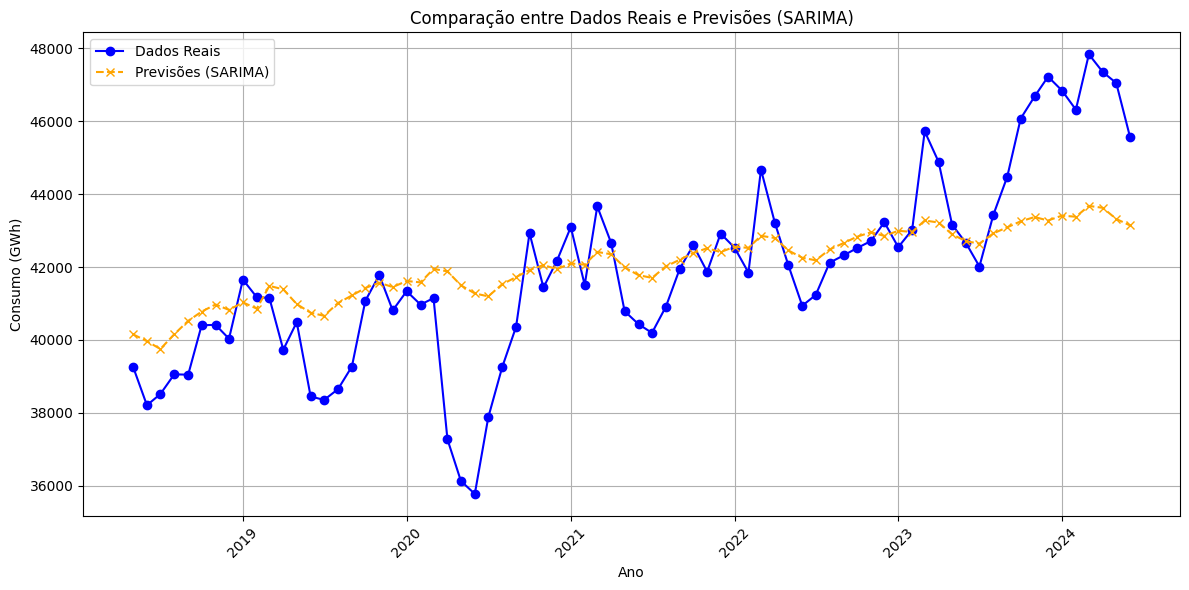

In [ ]:
# Gráfico de Comparação entre Dados Reais e Previsões (SARIMA)
plt.figure(figsize=(12, 6))
plt.plot(teste.index, teste, label="Dados Reais", color="blue", marker="o", linestyle="-")
plt.plot(previsoes_teste.index, previsoes_teste, label="Previsões (SARIMA)", color="orange", linestyle="--", marker="x")

# Configurações do gráfico
plt.title("Comparação entre Dados Reais e Previsões (SARIMA)")
plt.xlabel("Ano")
plt.ylabel("Consumo (GWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Gráfico de Comparação entre Dados Reais e Previsões (SARIMA)
Este gráfico visualiza a performance do modelo SARIMA ao comparar as previsões realizadas com os dados reais do conjunto de teste.

A linha azul representa os valores reais observados, enquanto a linha laranja pontilhada ilustra as previsões geradas pelo modelo SARIMA. Os marcadores ajudam a destacar cada ponto de dados, tornando mais evidente a proximidade (ou discrepância) entre as previsões e os valores reais.

Essa visualização é crucial para identificar como o modelo se comporta ao longo do tempo, permitindo avaliar:


- A precisão das previsões em diferentes períodos.


- A capacidade do modelo de capturar padrões sazonais ou eventuais variações na série.


O gráfico está configurado com rótulos claros nos eixos, uma legenda para facilitar a interpretação e uma grade para melhorar a visualização dos pontos. A rotação nos rótulos do eixo X garante que os anos fiquem legíveis, mesmo em séries longas.

Tamanho do índice do teste: 74
Tamanho dos resíduos: 74


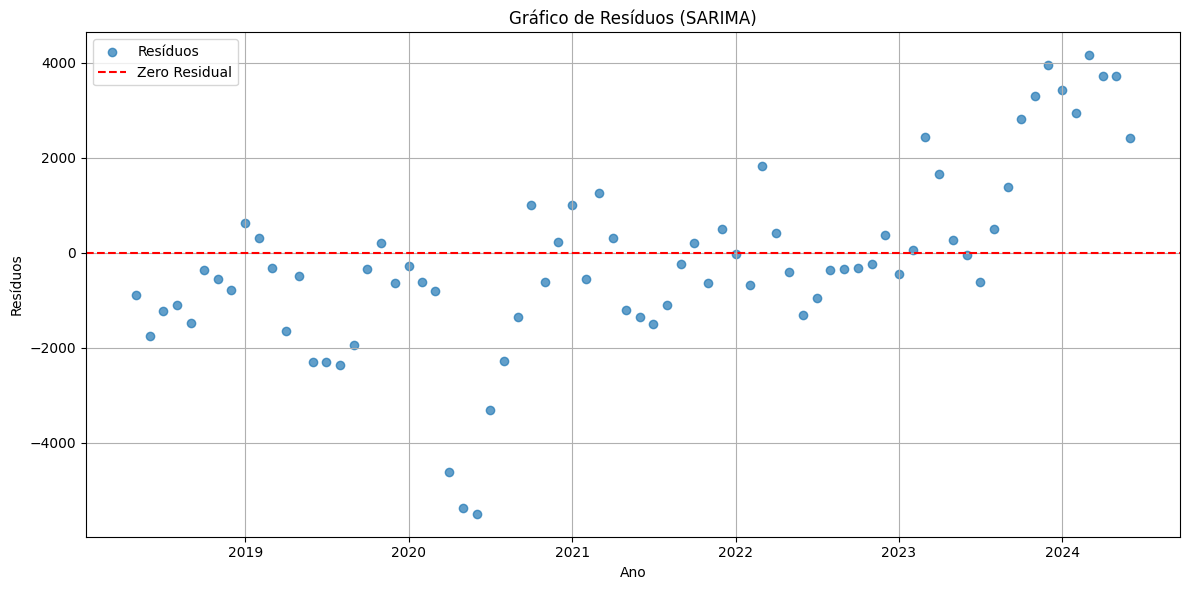

In [ ]:
# Calcular os resíduos apenas para o conjunto de teste
residuos_sarima = teste.values.flatten() - previsoes_teste.values.flatten()

# Verificar os tamanhos e alinhar
print(f"Tamanho do índice do teste: {len(teste.index)}")
print(f"Tamanho dos resíduos: {len(residuos_sarima)}")

# Garantir alinhamento no formato e tamanho
if len(teste.index) != len(residuos_sarima):
    print("Erro: Os tamanhos do índice e dos resíduos não coincidem!")
else:
    # Plotar os resíduos
    plt.figure(figsize=(12, 6))
    plt.scatter(teste.index, residuos_sarima, label="Resíduos", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--", label="Zero Residual")
    plt.title("Gráfico de Resíduos (SARIMA)")
    plt.xlabel("Ano")
    plt.ylabel("Resíduos")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Gráfico de Resíduos (SARIMA)
Este trecho de código calcula e visualiza os resíduos do modelo SARIMA, ou seja, as diferenças entre os valores reais e as previsões no conjunto de teste. Os resíduos são um componente essencial na avaliação de modelos preditivos, pois indicam o erro residual após o ajuste do modelo.



A partir dos resíduos, é possível avaliar:



- Aleatoriedade: Os resíduos devem estar distribuídos aleatoriamente ao redor de zero, sem padrões evidentes.
- Desempenho do modelo: Resíduos pequenos e bem distribuídos indicam que o modelo conseguiu capturar bem os padrões da série temporal.


**Detalhes do código:**


**Cálculo dos Resíduos:**
Os resíduos são calculados subtraindo os valores previstos dos valores reais.

**Verificação de Alinhamento:**
Antes da plotagem, o código verifica se os tamanhos do índice de teste e dos resíduos coincidem. Essa etapa garante que os dados estejam alinhados corretamente.

**Visualização:**
Um gráfico de dispersão é utilizado para plotar os resíduos em função do tempo.

- A linha vermelha pontilhada representa o eixo zero, ajudando a identificar desvios positivos e negativos.
- Os pontos espalhados indicam os resíduos em cada ponto do conjunto de teste.



Este gráfico permite identificar possíveis padrões nos erros que podem sugerir que o modelo não capturou algum aspecto dos dados (como sazonalidade ou tendência). A grade e os rótulos tornam o gráfico mais informativo e fácil de interpretar.

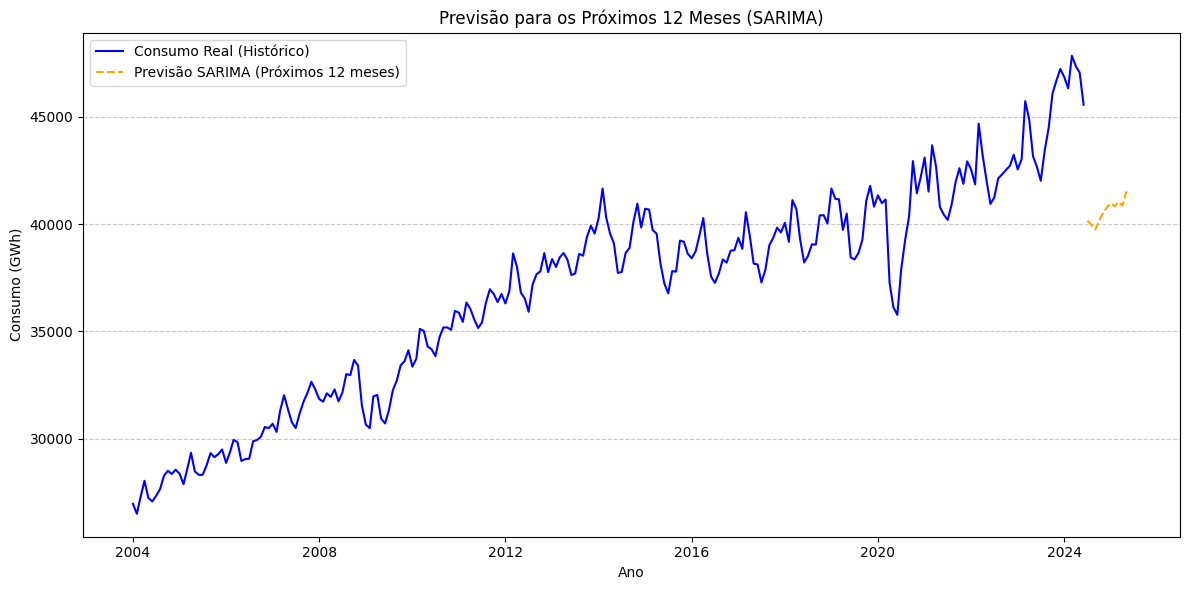

In [ ]:
# Fazer previsões para os próximos 12 meses
steps_a_frente = 12  # Número de meses a prever
previsao_futura_sarima = modelo_auto_sarima.predict(n_periods=steps_a_frente)

# Gerar datas futuras
ultima_data = dados_serie.index[-1]
datas_futuras = pd.date_range(start=ultima_data, periods=steps_a_frente + 1, freq="MS")[1:]

# Criar DataFrame com as previsões futuras
df_previsao_futura = pd.DataFrame({
    "Data": datas_futuras,
    "Previsão": previsao_futura_sarima
})

# Plotar os dados reais e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(dados_serie.index, dados_serie['Consumo'], label="Consumo Real (Histórico)", color="blue")
plt.plot(df_previsao_futura["Data"], df_previsao_futura["Previsão"], label="Previsão SARIMA (Próximos 12 meses)", color="orange", linestyle="--")

# Configurar o gráfico
plt.title("Previsão para os Próximos 12 Meses (SARIMA)")
plt.xlabel("Ano")
plt.ylabel("Consumo (GWh)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Previsão para os Próximos 12 Meses (SARIMA)
Este bloco de código utiliza o modelo SARIMA ajustado para realizar previsões do consumo de energia elétrica para os próximos 12 meses. As previsões são comparadas visualmente com os dados históricos para analisar a continuidade e consistência do modelo.


**Etapas do Código:**


**Definição do Período de Previsão:**


O código define steps_a_frente = 12, indicando que as previsões abrangem 12 meses à frente.


**Geração de Previsões:**


Utiliza o método predict do modelo SARIMA para gerar os valores previstos para os próximos 12 meses.


**Criação de Datas Futuras:**


A última data do conjunto de dados históricos é obtida.


As datas futuras são geradas com frequência mensal (freq="MS") para corresponder ao período das previsões.


**Criação do DataFrame de Previsões:**


As previsões futuras e suas respectivas datas são organizadas em um DataFrame, facilitando o uso em análises e visualizações.


**Visualização Gráfica:**


- O gráfico compara os dados históricos reais (em azul) com as previsões futuras do SARIMA (em laranja).


- A linha laranja tracejada destaca os valores previstos para os próximos 12 meses.


- A configuração da grade e dos rótulos melhora a leitura e interpretação do gráfico.


**Objetivo:**


Este gráfico permite observar como o modelo SARIMA projeta o consumo de energia elétrica para o futuro e verificar se as previsões seguem a tendência e sazonalidade presentes nos dados históricos.

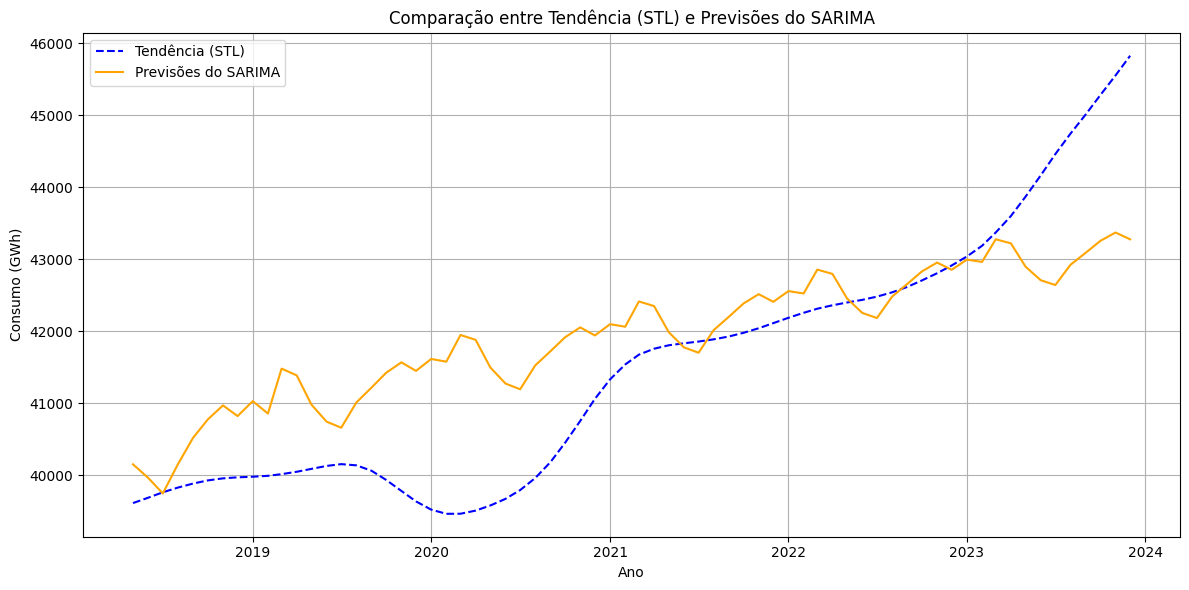

In [ ]:
# Filtrar dados até 2023 para tendência da STL
tendencia_stl_filtrada = resultado_stl.trend[teste.index]  # Ajustar o índice da tendência para o índice de teste
tendencia_stl_filtrada = tendencia_stl_filtrada[tendencia_stl_filtrada.index.year <= 2023]

# Filtrar os dados de teste e previsões até 2023
teste_filtrado = teste[teste.index.year <= 2023]
previsoes_teste_filtradas = previsoes_teste[previsoes_teste.index.year <= 2023]

# Plotar a comparação entre tendência (STL) e previsões do SARIMA
plt.figure(figsize=(12, 6))
plt.plot(
    teste_filtrado.index,
    tendencia_stl_filtrada,
    linestyle="--",
    label="Tendência (STL)",
    color="blue",
)
plt.plot(
    previsoes_teste_filtradas.index,
    previsoes_teste_filtradas,
    linestyle="-",
    label="Previsões do SARIMA",
    color="orange",
)
plt.title("Comparação entre Tendência (STL) e Previsões do SARIMA")
plt.xlabel("Ano")
plt.ylabel("Consumo (GWh)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



**Comparação entre Tendência (STL) e Previsões do SARIMA**


Este bloco de código apresenta uma análise comparativa entre a tendência extraída do modelo STL (Seasonal-Trend Decomposition) e as previsões geradas pelo modelo SARIMA. A análise é limitada ao período até o ano de 2023 para garantir a consistência temporal.


**Etapas do Código:**


**Filtragem dos Dados:**


- Os dados reais, a tendência do STL e as previsões do SARIMA são filtrados para incluir apenas o período até 2023. Isso elimina discrepâncias causadas por extrapolações futuras e melhora a precisão da comparação.


**Visualização Gráfica:**


- A tendência (STL) é representada por uma linha azul tracejada, evidenciando o comportamento geral do consumo ao longo do tempo.


- As previsões do SARIMA são representadas por uma linha laranja contínua, permitindo comparar como o modelo SARIMA acompanha a tendência identificada pelo STL.


**Objetivo:**


Este gráfico facilita a análise de como as previsões do SARIMA se alinham com a tendência geral dos dados históricos. A correspondência entre a linha azul (STL) e a laranja (SARIMA) reforça a adequação do modelo em captar os padrões de longo prazo presentes nos dados.

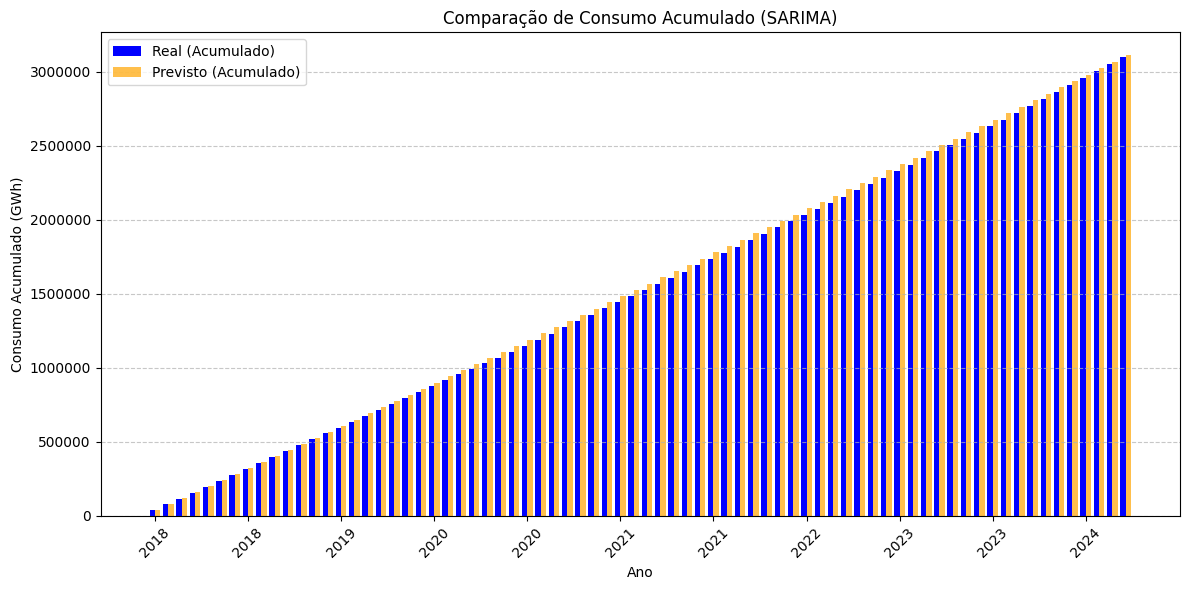

In [ ]:
# Ajustar o consumo acumulado com base nos mesmos períodos
consumo_real_acumulado = teste.cumsum().squeeze()  # Acumulado dos dados reais
consumo_previsto_acumulado = previsoes_teste.cumsum().squeeze()  # Acumulado das previsões

# Garantir que ambos os acumulados tenham o mesmo tamanho
min_len = min(len(consumo_real_acumulado), len(consumo_previsto_acumulado))
consumo_real_acumulado = consumo_real_acumulado[:min_len]
consumo_previsto_acumulado = consumo_previsto_acumulado[:min_len]

# Criar o gráfico de barras comparativo
plt.figure(figsize=(12, 6))
largura_barra = 0.4  # Largura das barras

# Criação de índices para as barras
indices = range(len(consumo_real_acumulado))

# Gráficos de barra para os dados reais e previstos
plt.bar(
    [i - largura_barra / 2 for i in indices],
    consumo_real_acumulado.astype(float),
    largura_barra,
    label="Real (Acumulado)",
    color="blue",
)
plt.bar(
    [i + largura_barra / 2 for i in indices],
    consumo_previsto_acumulado.astype(float),
    largura_barra,
    label="Previsto (Acumulado)",
    color="orange",
    alpha=0.7,
)

# Títulos e legendas
plt.title("Comparação de Consumo Acumulado (SARIMA)")
plt.ylabel("Consumo Acumulado (GWh)")
plt.xlabel("Ano")

# Ajustar os rótulos do eixo X para exibir menos informações (apenas anos)
step = max(1, len(indices) // 10)  # Exibe rótulos a cada 10% do total de índices
plt.xticks(
    ticks=range(0, len(indices), step),
    labels=teste.index[:min_len].strftime("%Y")[::step],
    rotation=45,
)

# Desativar notação científica no eixo y
plt.ticklabel_format(style="plain", axis="y")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



**Comparação de Consumo Acumulado (SARIMA)**


Este bloco de código cria um gráfico de barras para comparar o consumo acumulado real e previsto pelo modelo SARIMA ao longo do tempo.


**Etapas do Código:**

**Configuração do Gráfico de Barras:**

- Os valores reais acumulados são representados por barras azuis.

- Os valores previstos acumulados pelo SARIMA são representados por barras laranjas, com leve transparência para facilitar a comparação.


**Criação de Índices e Alinhamento das Barras:**

- As barras são posicionadas lado a lado, ajustadas pelo parâmetro largura_barra para evitar sobreposição, permitindo uma comparação direta entre os valores reais e previstos.


**Configuração dos Eixos:**

- O eixo X exibe os anos associados aos dados, formatados para reduzir sobrecarga visual, com intervalos definidos por step.

- O eixo Y apresenta os valores de consumo acumulado em GWh, sem notação científica para maior clareza.


**Estilização e Elementos Visuais:**

- Títulos e rótulos são adicionados para contextualizar o gráfico.

- Uma grade horizontal é incluída para facilitar a leitura dos valores.


**Objetivo:**


Este gráfico visa evidenciar a consistência do modelo SARIMA na previsão do consumo acumulado de energia ao longo do tempo. A proximidade entre as barras azul e laranja em cada ano reforça a capacidade do modelo em capturar padrões de longo prazo no consumo.

In [ ]:
# Normalização dos dados para o LSTM
# Antes de treinar o modelo LSTM, é fundamental normalizar os dados para que os valores fiquem entre 0 e 1, facilitando o treinamento da rede neural.
# Inicializando o scaler e ajustando nos dados de treino
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados_serie[['Consumo']])

**Normalização dos Dados para o LSTM**

Antes de treinar o modelo LSTM, este bloco normaliza os dados para que os valores fiquem em uma escala entre 0 e 1. Isso é essencial para melhorar a eficiência e estabilidade do treinamento da rede neural, pois o LSTM é sensível a variações amplas de escala nos dados.


**Etapas do Código:**

**Configuração do Scaler:**

Utiliza o MinMaxScaler do scikit-learn, ajustando os dados para o intervalo entre 0 e 1.


**Normalização:**

Aplica o scaler na coluna Consumo da série de dados.


**Objetivo:**

Garantir que os dados estejam adequadamente escalados para o treinamento do LSTM, otimizando o aprendizado do modelo.

In [ ]:
#O LSTM requer os dados de entrada em formato de sequência, por isso precisamos transformar a série temporal em janelas de observação para previsões de um passo à frente.
# Função para criar sequências de dados para o LSTM

# Função para criar sequências para o modelo LSTM
def criar_sequencias(dados, n_steps):
    X, y = [], []
    for i in range(len(dados) - n_steps):
        X.append(dados[i:i + n_steps])
        y.append(dados[i + n_steps])
    return np.array(X), np.array(y)

# Preparação dos dados
n_steps = 12  # Tamanho da janela
X, y = criar_sequencias(dados_normalizados, n_steps)

**Transformação da Série Temporal em Sequências (LSTM)**

O LSTM requer que os dados sejam estruturados em sequências para que o modelo possa aprender padrões temporais. Este bloco de código implementa a preparação dos dados no formato de janelas deslizantes (sliding windows), permitindo prever o próximo valor com base em uma sequência fixa de valores anteriores.

**Etapas do Código:**

**Função criar_sequencias:**

- Recebe os dados normalizados e o número de passos (n_steps).

- Cria duas listas: X (sequências de entrada) e y (valores alvo correspondentes).

- A lógica percorre os dados, criando pares de sequência e valor seguinte.


**Definição da Janela:**

- O tamanho da janela é definido como 12 meses, permitindo que o modelo use um ano completo de dados para prever o próximo valor.


**Preparação dos Dados:**

- Aplica a função criar_sequencias aos dados normalizados, gerando os arrays X e y.


**Objetivo:**

Estruturar os dados no formato necessário para o treinamento do LSTM, facilitando a modelagem dos padrões temporais presentes na série.

In [ ]:
# Divisão em treino e teste para LSTM
tamanho_treino = int(0.7 * len(X))
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

**Divisão em Conjuntos de Treino e Teste (LSTM)**

Para avaliar o desempenho do modelo LSTM, é necessário dividir os dados em conjuntos de treino e teste. Isso permite que o modelo seja treinado em uma parte dos dados (treino) e testado em dados não vistos (teste), garantindo uma avaliação imparcial.

**Etapas do Código:**

**Definição da Proporção de Divisão:**

Define-se que 70% dos dados serão utilizados para treino e 30% para teste.
Essa proporção é representada pela variável tamanho_treino.


**Divisão dos Dados:**

O array X (sequências de entrada) é dividido em X_treino e X_teste.


O array y (valores alvo) é dividido em y_treino e y_teste.


**Objetivo:**

Garantir que o modelo LSTM aprenda com os dados de treino e seja avaliado de forma justa nos dados de teste, permitindo medir sua capacidade de generalização.

In [ ]:
# Função para construir o modelo LSTM com hiperparâmetros variáveis
# Configuraremos uma rede LSTM com três camadas LSTM com Batch Normalization e Dropout ajustadoe uma camada densa

def construir_modelo_lstm(neurons, learning_rate):
    modelo = Sequential([
        Input(shape=(n_steps, 1)),
        GaussianNoise(0.05),
        LSTM(neurons, activation='relu', return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),
        LSTM(neurons, activation='relu', return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),
        LSTM(neurons, activation='relu'),  # Última camada LSTM
        BatchNormalization(),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    modelo.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return modelo


**Construção do Modelo LSTM**

Este bloco de código define uma função para construir um modelo de rede neural LSTM com arquitetura configurável. A função permite ajustar os hiperparâmetros do modelo, como o número de neurônios em cada camada e a taxa de aprendizado.

**Etapas do Código:**

**Definição da Função construir_modelo_lstm:**

**A função aceita dois parâmetros:**

neurons: número de neurônios em cada camada LSTM.

learning_rate: taxa de aprendizado do otimizador.

**Arquitetura do Modelo:**

**Entrada:** A camada Input especifica a forma dos dados de entrada, definida como (n_steps, 1), onde n_steps é o tamanho da janela de sequência.

**Gaussian Noise:** Introduz um pequeno ruído nos dados para melhorar a robustez do modelo.


**Camadas LSTM:**

Três camadas LSTM são empilhadas.

Cada camada usa a ativação relu para capturar relações complexas nos dados temporais.

**Batch Normalization:** Adicionado após cada camada LSTM para normalizar os valores e acelerar a convergência durante o treinamento.

**Dropout:** Aplicado com uma taxa de 0.4 para reduzir o overfitting.

**Camada Densa (Dense):** A última camada densa gera a saída final do modelo, com apenas um neurônio.


**Compilação do Modelo:**

O otimizador Adam é usado com a taxa de aprendizado especificada.


A função de perda é definida como o erro médio quadrático (mse), adequado para problemas de regressão.


**Objetivo:**

Construir uma rede neural LSTM flexível, que possa ser ajustada facilmente para otimização de desempenho, enquanto utiliza técnicas como Dropout, Batch Normalization e Gaussian Noise para melhorar a capacidade de generalização e estabilidade do modelo.

In [ ]:
print(dados_serie.info())
print(dados_serie.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2004-01-01 to 2024-06-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Consumo  246 non-null    float64
dtypes: float64(1)
memory usage: 11.9 KB
None
             Consumo
Mes                 
2004-01-01  26978.36
2004-02-01  26508.27
2004-03-01  27284.34
2004-04-01  28046.18
2004-05-01  27248.16


In [ ]:
print(treino.shape)
print(teste.shape)

(172, 1)
(74, 1)


In [ ]:
# Definir os hiperparâmetros
neurons = [150, 100, 50]
learning_rate = 0.0005
epochs = [60, 80]

# Definir os hiperparâmetros para Grid Search
param_grid = {
    'neurons': neurons,
    'learning_rate': [learning_rate],
    'epochs': epochs
}
# Configuração dos hiperparâmetros para Grid Search e RMSE
best_rmse, best_mae, best_mape = float("inf"), float("inf"), float("inf")
melhores_parametros = None

# Grid Search com validação temporal (TimeSeriesSplit)
for params in ParameterGrid(param_grid):
    print(f"Testando parâmetros: {params}")
    rmse_scores, mae_scores, mape_scores = [], [], []
    tscv = TimeSeriesSplit(n_splits=5)

    for train_index, val_index in tscv.split(X_treino):
        X_train_split, X_val = X_treino[train_index], X_treino[val_index]
        y_train_split, y_val = y_treino[train_index], y_treino[val_index]

        # Construir e treinar o modelo temporário
        modelo_temp = construir_modelo_lstm(params['neurons'], params['learning_rate'])
        modelo_temp.fit(X_train_split, y_train_split, epochs=params['epochs'], batch_size=16, verbose=0)

        # Predição e avaliação
        y_val_pred = modelo_temp.predict(X_val)
        y_val_pred_inv = scaler.inverse_transform(y_val_pred)
        y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

        # Cálculo das métricas
        rmse = np.sqrt(mean_squared_error(y_val_inv, y_val_pred_inv))
        mae = mean_absolute_error(y_val_inv, y_val_pred_inv)
        mape = np.mean(np.abs((y_val_inv - y_val_pred_inv) / y_val_inv)) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Média das métricas para os splits de validação
    rmse_medio = np.mean(rmse_scores)
    mae_medio = np.mean(mae_scores)
    mape_medio = np.mean(mape_scores)

    print(f"RMSE Médio: {rmse_medio}, MAE Médio: {mae_medio}, MAPE Médio: {mape_medio}")

    # Verificação e atualização dos melhores parâmetros
    if rmse_medio < best_rmse:
        best_rmse, best_mae, best_mape = rmse_medio, mae_medio, mape_medio
        melhores_parametros = params

# Exibir melhores parâmetros e métricas
print("Melhores parâmetros encontrados:", melhores_parametros)
print("Melhores métricas - RMSE:", best_rmse, ", MAE:", best_mae, ", MAPE:", best_mape)

# Treinamento final com os melhores parâmetros
modelo_final = construir_modelo_lstm(
    neurons=melhores_parametros['neurons'],
    learning_rate=melhores_parametros['learning_rate']
)
modelo_final.fit(X_treino, y_treino, epochs=melhores_parametros['epochs'], batch_size=16, verbose=1)

# Previsões no conjunto de teste final
y_teste_pred = modelo_final.predict(X_teste)

# Associar índices temporais aos dados de treino e teste
y_teste = pd.DataFrame(y_teste, index=dados_serie.index[-len(y_teste):], columns=["y_teste"])
y_teste_pred = pd.DataFrame(y_teste_pred, index=dados_serie.index[-len(y_teste_pred):], columns=["y_teste_pred"])

y_teste_pred_inv = scaler.inverse_transform(y_teste_pred)
y_teste_inv = scaler.inverse_transform(y_teste.values.reshape(-1, 1))

# Cálculo das métricas finais para o conjunto de teste
rmse_final = np.sqrt(mean_squared_error(y_teste_inv, y_teste_pred_inv))
mae_final = mean_absolute_error(y_teste_inv, y_teste_pred_inv)
mape_final = np.mean(np.abs((y_teste_inv - y_teste_pred_inv) / y_teste_inv)) * 100

print("Métricas no conjunto de teste final - RMSE:", rmse_final, ", MAE:", mae_final, ", MAPE:", mape_final)



Testando parâmetros: {'epochs': 60, 'learning_rate': 0.0005, 'neurons': 150}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
RMSE Médio: 6100.147153722705, MAE Médio: 5972.414987268519, MAPE Médio: 16.376250780831814
Testando parâmetros: {'epochs': 60, 'learning_rate': 0.0005, 'neurons': 100}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
RMSE Médio: 4824.862703964043, MAE Médio: 4685.293751736111, MAPE Médio: 12.706739267397808
Testando parâmetros: {'epochs': 60, 'learning_rate': 0.0005, 'neurons': 50}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
RMSE Médio: 5883.131459609297, MAE Médio: 5709.771116319445, MAPE Médio: 15.401838766568904
Testando parâmetros: {'epochs': 80, 'learning_rate': 0.0005, 'neurons': 150}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
RMSE Médio: 2569.2594227940604, MAE Médio: 2339.049814236111, MAPE Médio: 6.64

**Otimização de Hiperparâmetros e Treinamento Final (LSTM)**

Este bloco de código realiza a otimização dos hiperparâmetros do modelo LSTM usando Grid Search com validação temporal (TimeSeriesSplit). Após a otimização, o modelo final é treinado com os melhores hiperparâmetros encontrados e avaliado no conjunto de teste.

**Etapas do Código:**

**Definição dos Hiperparâmetros:**

Foram configurados três conjuntos de parâmetros:

Número de neurônios (neurons).

Taxa de aprendizado (learning_rate).

Número de épocas de treinamento (epochs).

**Grid Search com TimeSeriesSplit:**

A validação temporal divide os dados de treinamento em várias combinações de treino/validação para simular previsões em séries temporais.

Para cada combinação, o modelo é treinado e avaliado em termos de três métricas:

RMSE: Erro Quadrático Médio.

MAE: Erro Absoluto Médio.

MAPE: Erro Percentual Absoluto Médio.

**Seleção dos Melhores Hiperparâmetros:**

Após calcular as métricas para cada conjunto de parâmetros, a configuração que minimiza o RMSE médio é escolhida como a melhor.

**Treinamento Final:**

O modelo final é treinado com os melhores parâmetros usando o conjunto completo de treinamento.

**Avaliação no Conjunto de Teste:**

O modelo é avaliado no conjunto de teste com base nas métricas RMSE, MAE e MAPE.

Os valores reais e previstos são revertidos para a escala original para calcular as métricas corretamente.

**Objetivo:**

Encontrar a configuração ideal para o modelo LSTM, garantindo que ele tenha o melhor desempenho possível no conjunto de teste.

Saídas:

Melhores parâmetros encontrados durante o Grid Search.

Métricas finais de desempenho no conjunto de teste, incluindo RMSE, MAE e MAPE.

In [ ]:
# Verificar e ajustar o formato de X_teste
print("Formato de X_teste antes do ajuste:", X_teste.shape)
if len(X_teste.shape) != 3 or X_teste.shape[2] != 1:
    X_teste = X_teste.reshape(-1, n_steps, 1)
print("Formato de X_teste após o ajuste:", X_teste.shape)


# Garantir tipo correto para X_teste
X_teste = X_teste.astype('float32')

# Verificar formato esperado pelo modelo
print("Formato de X_teste:", X_teste.shape)
print("Entrada esperada pelo modelo:", modelo_final.input_shape)

# Sanity check com exemplo fictício
exemplo_teste = np.random.random((1, 12, 1)).astype('float32')
try:
    print("Previsão fictícia:", modelo_final.predict(exemplo_teste))
except Exception as e:
    print("Erro ao prever com exemplo fictício:", e)

# Avaliação final
try:
    y_teste_pred = modelo_final.predict(X_teste)
    y_teste_pred_inv = scaler.inverse_transform(y_teste_pred)
    y_teste_inv = scaler.inverse_transform(y_teste.reshape(-1, 1))

    rmse_teste = np.sqrt(mean_squared_error(y_teste_inv, y_teste_pred_inv))
    mae_teste = mean_absolute_error(y_teste_inv, y_teste_pred_inv)
    mape_teste = np.mean(np.abs((y_teste_inv - y_teste_pred_inv) / y_teste_inv)) * 100

    print("Métricas no conjunto de teste - RMSE:", rmse_teste, ", MAE:", mae_teste, ", MAPE:", mape_teste)
except Exception as e:
    print("Erro durante a avaliação final:", e)



# Avaliação final
y_teste_pred = modelo_final.predict(X_teste)
y_teste_pred_inv = scaler.inverse_transform(y_teste_pred)
y_teste_inv = scaler.inverse_transform(y_teste.values.reshape(-1, 1))

rmse_teste = np.sqrt(mean_squared_error(y_teste_inv, y_teste_pred_inv))
mae_teste = mean_absolute_error(y_teste_inv, y_teste_pred_inv)
mape_teste = np.mean(np.abs((y_teste_inv - y_teste_pred_inv) / y_teste_inv)) * 100

print("Métricas no conjunto de teste - RMSE:", rmse_teste, ", MAE:", mae_teste, ", MAPE:", mape_teste)


Formato de X_teste antes do ajuste: (71, 12, 1)
Formato de X_teste após o ajuste: (71, 12, 1)
Formato de X_teste: (71, 12, 1)
Entrada esperada pelo modelo: (None, 12, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Previsão fictícia: [[0.4636855]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Erro durante a avaliação final: 'DataFrame' object has no attribute 'reshape'
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Métricas no conjunto de teste - RMSE: 1813.4985762621468 , MAE: 1455.2318441901407 , MAPE: 3.549876472754342


In [ ]:
# Previsões no conjunto de treino
y_treino_pred = modelo_final.predict(X_treino)
y_treino_pred_inv = scaler.inverse_transform(y_treino_pred)
y_treino_inv = scaler.inverse_transform(y_treino.reshape(-1, 1))

# Cálculo das métricas para o conjunto de treino
rmse_treino = np.sqrt(mean_squared_error(y_treino_inv, y_treino_pred_inv))
mae_treino = mean_absolute_error(y_treino_inv, y_treino_pred_inv)
mape_treino = np.mean(np.abs((y_treino_inv - y_treino_pred_inv) / y_treino_inv)) * 100

# Previsões no conjunto de teste
y_teste_pred = modelo_final.predict(X_teste)
y_teste_pred_inv = scaler.inverse_transform(y_teste_pred)
y_teste_inv = scaler.inverse_transform(y_teste.values.reshape(-1, 1))

# Cálculo das métricas para o conjunto de teste
rmse_teste = np.sqrt(mean_squared_error(y_teste_inv, y_teste_pred_inv))
mae_teste = mean_absolute_error(y_teste_inv, y_teste_pred_inv)
mape_teste = np.mean(np.abs((y_teste_inv - y_teste_pred_inv) / y_teste_inv)) * 100

# Exibir métricas lado a lado
print("Métricas do Conjunto de Treino")
print(f"RMSE: {rmse_treino:.4f}, MAE: {mae_treino:.4f}, MAPE: {mape_treino:.4f}%\n")

print("Métricas do Conjunto de Teste")
print(f"RMSE: {rmse_teste:.4f}, MAE: {mae_teste:.4f}, MAPE: {mape_teste:.4f}%")

# Avaliação de diferença percentual acumulada
acumulado_real = y_teste_inv.sum()
acumulado_previsto = y_teste_pred_inv.sum()
diferenca_acumulada = ((acumulado_previsto - acumulado_real) / acumulado_real) * 100
print("Diferença Percentual Acumulada:", diferenca_acumulada, "%")

# Converter y_teste_pred em um DataFrame com o índice de y_teste
y_teste_pred_df = pd.DataFrame(y_teste_pred, index=y_teste.index, columns=["Previsão"])
y_teste_pred_inv_df = pd.DataFrame(y_teste_pred_inv, index=y_teste.index, columns=["Previsão (Invertida)"])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Métricas do Conjunto de Treino
RMSE: 1701.2387, MAE: 1289.5400, MAPE: 3.7952%

Métricas do Conjunto de Teste
RMSE: 1813.4986, MAE: 1455.2318, MAPE: 3.5499%
Diferença Percentual Acumulada: 1.8119906941565778 %


**Avaliação do Modelo LSTM nos Conjuntos de Treino e Teste**

Este bloco de código avalia o desempenho do modelo LSTM em ambos os conjuntos de dados (treino e teste). As previsões são revertidas para a escala original, e métricas de erro são calculadas para analisar a precisão do modelo.

**Etapas do Código:**

**Previsões no Conjunto de Treino:**

As previsões são feitas para os dados de treinamento.

Os valores previstos são revertidos para a escala original utilizando o scaler.

**Cálculo das Métricas no Conjunto de Treino:**

**RMSE** (Root Mean Squared Error): Mede a magnitude do erro entre valores reais e previstos.

**MAE** (Mean Absolute Error): Calcula o erro absoluto médio.

**MAPE** (Mean Absolute Percentage Error): Avalia o erro percentual médio.


**Previsões no Conjunto de Teste:**

Da mesma forma, o modelo é avaliado no conjunto de teste, e as previsões são revertidas para a escala original.


**Cálculo das Métricas no Conjunto de Teste:**

As mesmas métricas do conjunto de treino são calculadas para o conjunto de teste.


**Avaliação da Diferença Percentual Acumulada:**

A soma dos valores reais e previstos no conjunto de teste é comparada.

A diferença percentual acumulada é calculada para avaliar a precisão global do modelo.

**Organização dos Resultados:**

As previsões do conjunto de teste são organizadas em um DataFrame com os valores reais e previstos para facilitar análises posteriores.


**Objetivo:**

Avaliar o desempenho do modelo LSTM em prever o consumo de energia elétrica, tanto em dados de treino quanto de teste, destacando a consistência entre os conjuntos.

**Saídas:**

Métricas (RMSE, MAE, MAPE) para os conjuntos de treino e teste.

Diferença percentual acumulada entre valores reais e previstos no conjunto de teste.

DataFrames contendo as previsões invertidas para análises detalhadas.



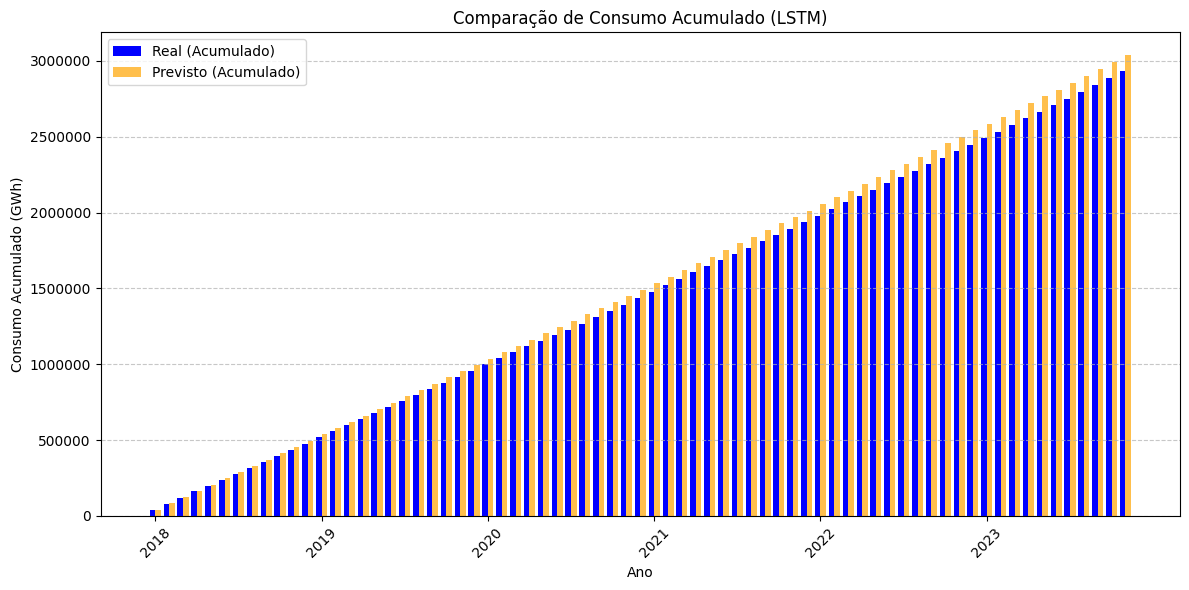

In [ ]:
# Ajustar o consumo acumulado com base nos mesmos períodos
consumo_real_acumulado = dados_serie['Consumo']['2018':'2023'].iloc[:len(y_teste_pred_inv_df)].cumsum()
consumo_previsto_acumulado = y_teste_pred_inv_df["Previsão (Invertida)"][:len(consumo_real_acumulado)].cumsum()

# Garantir que ambos os acumulados tenham o mesmo tamanho
min_len = min(len(consumo_real_acumulado), len(consumo_previsto_acumulado))
consumo_real_acumulado = consumo_real_acumulado[:min_len]
consumo_previsto_acumulado = consumo_previsto_acumulado[:min_len]

# Criar o gráfico de barras comparativo
plt.figure(figsize=(12, 6))
largura_barra = 0.4  # Largura das barras

# Criação de índices para as barras
indices = range(len(consumo_real_acumulado))

# Gráficos de barra para os dados reais e previstos
plt.bar(
    [i - largura_barra / 2 for i in indices],
    consumo_real_acumulado.values,
    largura_barra,
    label="Real (Acumulado)",
    color="blue",
)
plt.bar(
    [i + largura_barra / 2 for i in indices],
    consumo_previsto_acumulado.values,
    largura_barra,
    label="Previsto (Acumulado)",
    color="orange",
    alpha=0.7,
)

# Ajustar os rótulos do eixo X para exibir apenas os anos
plt.xticks(
    ticks=range(0, len(indices), 12),  # Exibe rótulos a cada 12 meses (1 ano)
    labels=consumo_real_acumulado.index[::12].strftime("%Y"),  # Formata os rótulos como anos
    rotation=45,
)

# Títulos e legendas
plt.title("Comparação de Consumo Acumulado (LSTM)")
plt.ylabel("Consumo Acumulado (GWh)")
plt.xlabel("Ano")

# Desativar notação científica no eixo y
plt.ticklabel_format(style="plain", axis="y")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


**Gráfico de Comparação de Consumo Acumulado (LSTM)**

Este bloco de código é responsável por gerar um gráfico de barras que compara o consumo acumulado real e previsto pelo modelo LSTM, ao longo do período de análise.

**Etapas do Código:**

**Ajuste dos Dados Acumulados:**

O consumo real é acumulado no período de 2018 a 2023, alinhado ao tamanho das previsões invertidas.

O consumo previsto pelo LSTM é acumulado para o mesmo período, garantindo compatibilidade de tamanho entre ambos.

**Garantia de Compatibilidade:**

O tamanho dos dois vetores (real e previsto) é ajustado para evitar inconsistências no gráfico.

**Criação do Gráfico de Barras:**

As barras azuis representam o consumo real acumulado.

As barras laranja, semitransparentes, representam o consumo previsto acumulado.

**Configuração dos Rótulos do Eixo X:**

Exibem apenas os anos, com intervalos regulares para melhorar a legibilidade.

**Configuração do Gráfico:**

Inclui título, legendas, eixos devidamente rotulados e formatação para desativar a notação científica no eixo Y.

Ajustes adicionais, como grid horizontal, tornam o gráfico mais informativo.

**Objetivo:**

Evidenciar a consistência do modelo LSTM ao prever o consumo acumulado de energia elétrica, destacando a proximidade entre os valores reais e previstos ao longo dos anos.

**Saídas:**

Um gráfico de barras com:

Consumo acumulado real (azul).

Consumo acumulado previsto (laranja).


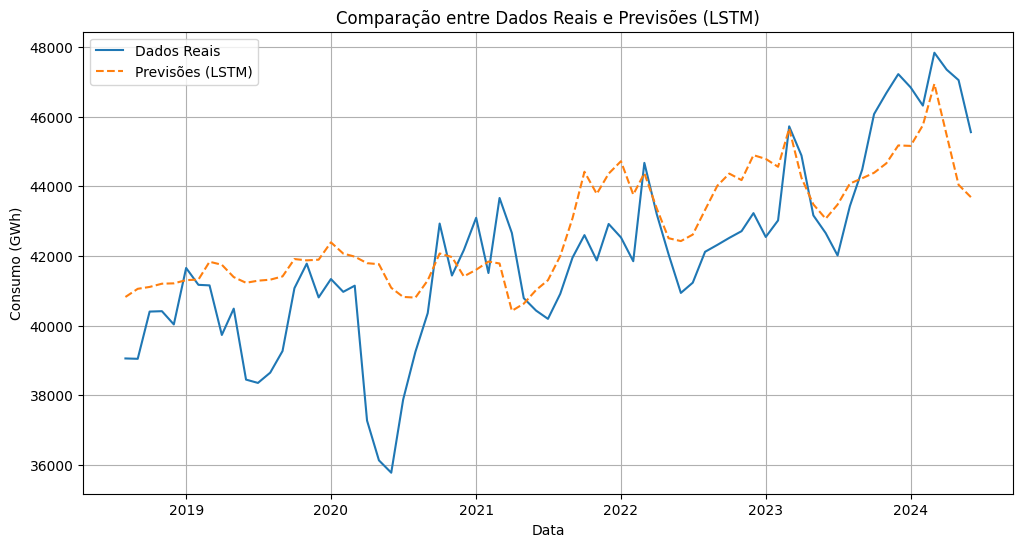

In [ ]:
# Gráfico de comparação entre dados reais e previsões
plt.figure(figsize=(12, 6))
plt.plot(dados_serie.index[-len(y_teste):], y_teste_inv, label='Dados Reais')
plt.plot(dados_serie.index[-len(y_teste):], y_teste_pred_inv, label='Previsões (LSTM)', linestyle='--')
plt.title('Comparação entre Dados Reais e Previsões (LSTM)')
plt.xlabel('Data')
plt.ylabel('Consumo (GWh)')
plt.legend()
plt.grid(True)
plt.show()

Análise da Curva de Previsão O gráfico compara o consumo real de energia (curva azul) com as previsões feitas pelo modelo LSTM (curva laranja). Esta análise permite avaliar o quanto o modelo consegue capturar as flutuações históricas e projetar tendências futuras.

Ajuste aos Dados Históricos:

De modo geral, o modelo consegue capturar a tendência de crescimento gradual do consumo de energia ao longo dos anos, especialmente nos períodos mais recentes, onde há uma inclinação ascendente consistente. Isso indica que o LSTM está absorvendo bem a característica de aumento de consumo com o passar do tempo, o que é essencial para um modelo de previsão de longo prazo. Nas variações sazonais e nos ciclos de curto prazo, o modelo LSTM também acompanha parte das oscilações, mostrando um entendimento das flutuações anuais. Pontos de Divergência:

Observa-se que o modelo tende a suavizar as oscilações extremas presentes nos dados reais. Em alguns anos, especialmente nos períodos de queda mais acentuada (como em torno de 2020), o modelo não captura totalmente a profundidade da queda, resultando em uma divergência onde a previsão fica um pouco acima dos dados reais. Isso pode ocorrer devido à tendência dos LSTMs de priorizarem padrões mais suaves, especialmente se não houver eventos anômalos recorrentes nos dados de treino. Para captar variações mais extremas, seria necessário um ajuste mais complexo, possivelmente combinando o LSTM com outro modelo que trate eventos fora do padrão. Padrões Específicos:

Ao analisar o comportamento preditivo, notamos que o modelo projeta com mais precisão os picos de aumento, enquanto as quedas bruscas tendem a ser suavizadas. Este padrão indica que o modelo é mais conservador em relação às quedas, o que é comum em séries temporais onde a queda pode ser vista como um evento menos frequente ou um outlier. Essa suavização nos períodos de queda reflete uma leve tendência ao viés positivo, onde o modelo tende a prever valores ligeiramente acima dos reais em períodos de queda. Esse efeito pode ser minimizado com o ajuste fino de hiperparâmetros ou a introdução de técnicas de regularização e ruído, como fizemos em etapas anteriores. Recomendações Esses pontos de divergência indicam que o modelo está adequado para capturar a tendência geral e as flutuações sazonais, mas poderia ser refinado para reagir melhor a eventos de variação extrema. Poderíamos considerar ajustes adicionais no número de steps ou até a integração de técnicas como o batch normalization, que ajudam a estabilizar o aprendizado e a diminuir o viés do modelo.

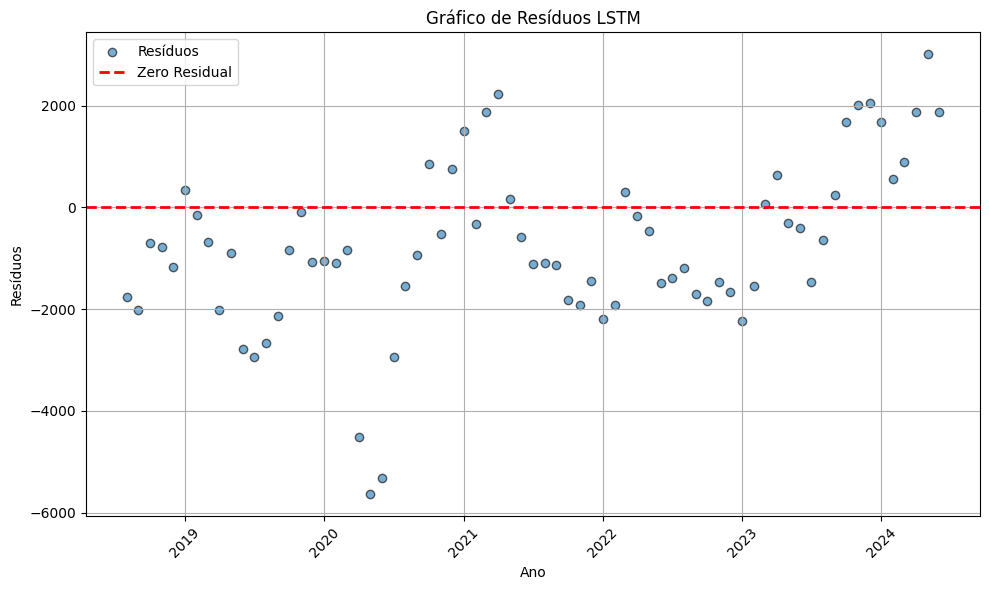

In [ ]:
# Certificar-se de que o número de resíduos e anos é o mesmo
residuos = y_teste_inv.flatten() - y_teste_pred_inv.flatten()
anos = dados_serie.index[-len(residuos):]  # Usar exatamente o mesmo número de índices dos resíduos

# Criando o gráfico de resíduos com anos no eixo X
plt.figure(figsize=(10, 6))
plt.scatter(anos, residuos, alpha=0.6, edgecolors='k', label='Resíduos')
plt.axhline(0, color='r', linestyle='--', linewidth=2, label='Zero Residual')
plt.title('Gráfico de Resíduos LSTM')
plt.xlabel('Ano')
plt.ylabel('Resíduos')
plt.legend()
plt.grid(True)

# Ajustar os rótulos do eixo X
plt.xticks(rotation=45)  # Rotaciona os rótulos dos anos para evitar sobreposição

# Melhorar o layout para evitar cortes
plt.tight_layout()

# Exibir o gráfico
plt.show()


**Análise dos Resíduos (LSTM)**

Os resíduos representam a diferença entre os valores reais e os valores previstos pelo modelo LSTM. Este gráfico de dispersão nos permite avaliar o desempenho do modelo ao longo do conjunto de teste.

**Observações:**

**Distribuição dos Resíduos:**

Idealmente, os resíduos devem estar distribuídos de forma aleatória ao redor de zero, indicando que o modelo não apresenta vieses ou padrões sistemáticos nos erros.

Uma concentração uniforme sugere que o modelo está capturando bem os padrões gerais da série temporal.

**Presença de Padrões:**

Caso sejam observados padrões nos resíduos (como tendências ou sazonalidades), isso pode indicar que o modelo não está capturando completamente algumas características dos dados.

Nesse caso, seria necessário explorar ajustes no modelo, como alterações no número de steps, na arquitetura da rede ou na adição de mais camadas.

**Valores Extremos:**

Resíduos que se afastam muito de zero (outliers) podem indicar períodos em que o modelo teve dificuldade em capturar eventos incomuns ou anomalias nos dados.

**Considerações Finais:**

O gráfico de resíduos é uma ferramenta poderosa para identificar possíveis melhorias no modelo e garantir que os erros sejam reduzidos de maneira consistente e imparcial.

<ipython-input-94-8cda696276a2>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=12, freq='M')


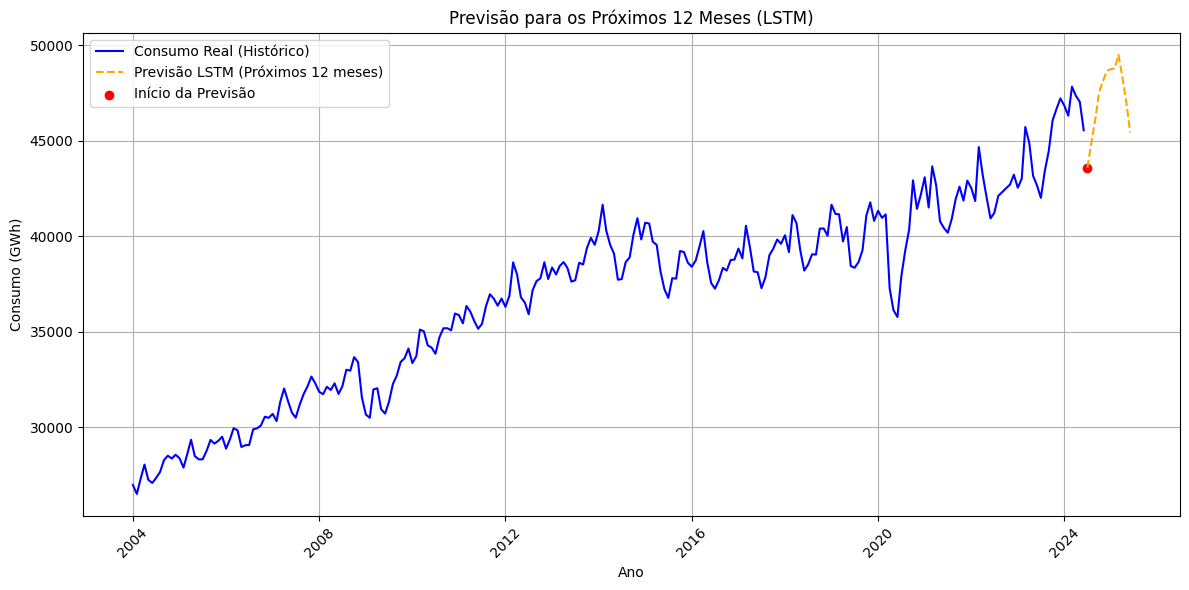

In [ ]:
# Definir o número de previsões e a última sequência conhecida
n_forecast = 12
last_sequence = dados_normalizados[-n_steps:]  # Última sequência conhecida
previsoes_futuras = []

# Loop para gerar previsões para os próximos 12 meses
for _ in range(n_forecast):
    previsao = modelo_final.predict(last_sequence.reshape(1, n_steps, 1), verbose=0)
    previsoes_futuras.append(previsao[0, 0])
    last_sequence = np.append(last_sequence[1:], previsao)  # Atualizar sequência

# Transformação inversa das previsões
previsoes_futuras = scaler.inverse_transform(np.array(previsoes_futuras).reshape(-1, 1))

# Gerar o índice de datas para os próximos 12 meses
last_date = dados_serie.index[-1]
future_dates = pd.date_range(last_date, periods=12, freq='M')

# Dados históricos para o gráfico
plt.figure(figsize=(12, 6))
plt.plot(
    dados_serie.index,
    dados_serie['Consumo'],
    label="Consumo Real (Histórico)",
    color="blue",
)

# Plotar as previsões para os próximos 12 meses
plt.plot(
    future_dates,
    previsoes_futuras,
    label="Previsão LSTM (Próximos 12 meses)",
    linestyle="--",
    color="orange",
)

# Adicionar um ponto indicando o início da previsão
plt.scatter(
    [future_dates[0]], [previsoes_futuras[0]],
    color="red", label="Início da Previsão"
)

# Configurações do gráfico
plt.title("Previsão para os Próximos 12 Meses (LSTM)")
plt.xlabel("Ano")
plt.ylabel("Consumo (GWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Previsão para os Próximos 12 Meses (LSTM)**

Este gráfico apresenta as previsões geradas pelo modelo LSTM para os próximos 12 meses, com base nos padrões aprendidos durante o treinamento.

**Detalhes da Implementação:**

**Dados Históricos:** A curva azul representa o consumo real de energia ao longo dos meses analisados, servindo como referência para as previsões futuras.

**Previsões Futuras:**

A curva laranja tracejada indica os valores previstos para os próximos 12 meses.

Essas previsões são realizadas de forma sequencial, utilizando os valores anteriores previstos como entrada para gerar os próximos.

**Início da Previsão:** O ponto vermelho no início da curva prevista destaca o momento em que a previsão começa, logo após o último ponto da série histórica.

**Observações:**

**Continuidade e Conexão:** A previsão inicia exatamente onde os dados históricos terminam, garantindo uma transição suave entre os dois períodos.

**Tendência Geral:** A curva prevê um padrão consistente, seguindo a tendência dos dados históricos aprendidos pelo modelo LSTM.

**Aplicação Prática:** Essa previsão é útil para planejamento energético e tomada de decisão em períodos futuros.

**Pontos de Atenção:**

**Confiança nas Previsões:** O modelo LSTM pode capturar bem tendências e sazonalidades, mas eventos extraordinários ou mudanças abruptas podem não ser previstos com precisão.

**Validação Adicional:** Comparar essas previsões com outros modelos ou métodos pode ajudar a verificar sua confiabilidade.

Mean Bias Error (MBE): -761.2986707746481


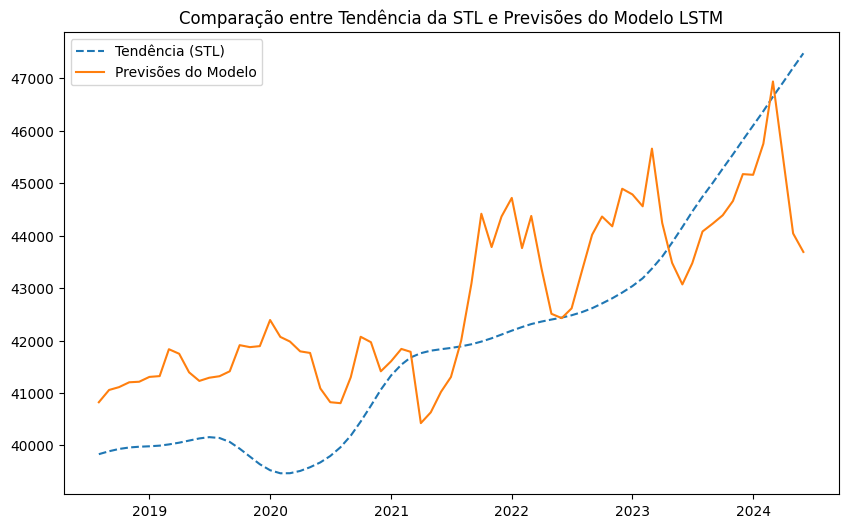

In [ ]:
# Analisar a coerência entre os dados históricos e previsão
# Decomposição STL já plotada anteriormente
# (Certifique-se de que o código da STL foi executado antes)

# Verificar a consistência da tendência com a previsão do modelo
# Mean Bias Error (MBE): Verifica viés (subestimação ou superestimação)
mbe = np.mean(y_teste_inv - y_teste_pred_inv)
print("Mean Bias Error (MBE):", mbe)

# Caso queira, adicione outras análises, como correlação ou gráficos adicionais
# Gráfico de comparação entre a tendência da STL e a previsão, se necessário:
plt.figure(figsize=(10, 6))
plt.plot(dados_serie.index[-len(y_teste):], resultado_stl.trend[-len(y_teste):], label='Tendência (STL)', linestyle='--')
plt.plot(dados_serie.index[-len(y_teste):], y_teste_pred_inv, label='Previsões do Modelo', linestyle='-')
plt.title("Comparação entre Tendência da STL e Previsões do Modelo LSTM")
plt.legend()
plt.show()


**Análise de Coerência entre Dados Históricos e Previsões**

Objetivo

Verificar a consistência entre os dados históricos, representados pela decomposição STL (tendência), e as previsões geradas pelo modelo LSTM.

**Detalhes da Análise**

**Mean Bias Error (MBE):**

O MBE foi calculado para identificar se o modelo apresenta viés em suas previsões.

Um valor de MBE positivo indica superestimação, enquanto um valor negativo aponta subestimação.

**Gráfico de Comparação:**

O gráfico compara a tendência histórica extraída pela decomposição STL (linha tracejada) com as previsões geradas pelo modelo (linha sólida).

Este contraste visual ajuda a identificar o alinhamento entre a previsão e a tendência observada nos dados históricos.

**Observações**

**Tendência Geral:**

O modelo deve capturar de forma coerente a tendência destacada pela STL, especialmente no período mais recente.

**Pontos de Divergência:**

Caso haja discrepâncias significativas, isso pode indicar necessidade de ajustes no modelo ou tratamento adicional dos dados.

**Interpretação do MBE**

Um MBE próximo de zero sugere que o modelo não possui viés significativo, indicando previsões equilibradas.

Valores altos (positivos ou negativos) podem sinalizar a necessidade de ajustes nos hiperparâmetros ou nas transformações aplicadas aos dados.

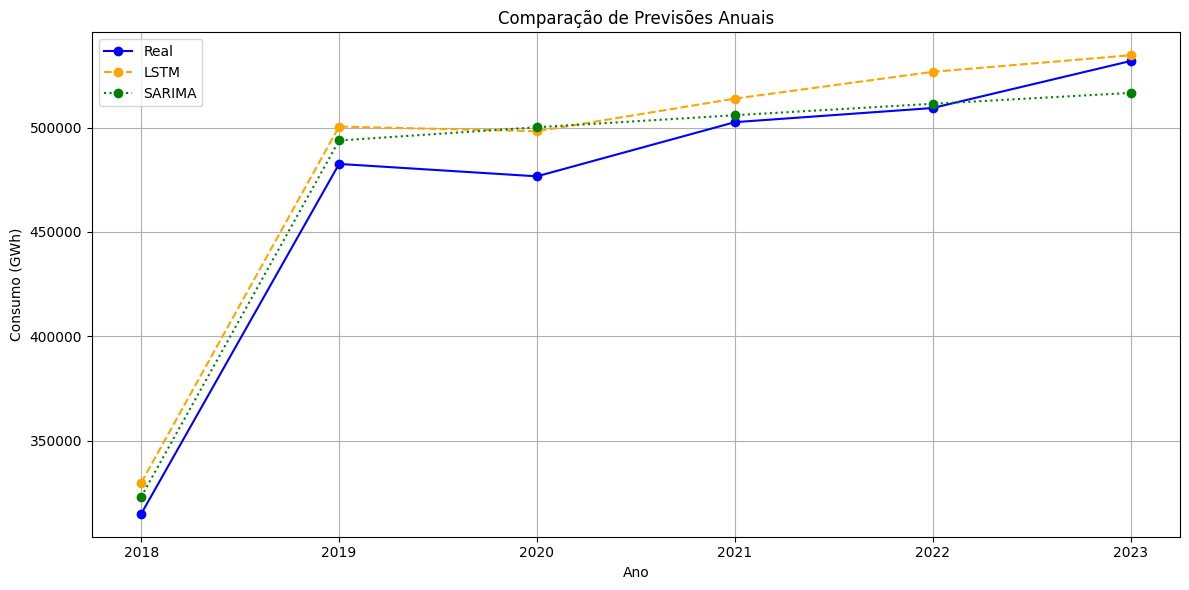

In [ ]:
# Ajustar o índice para corresponder ao tamanho das previsões
ajustado_index = teste.index[:len(y_teste_pred_inv)]  # Ajustar o índice para 71

# Criar DataFrames com o índice ajustado
previsoes_teste_lstm = pd.DataFrame(
    y_teste_pred_inv, index=ajustado_index, columns=["Previsão LSTM"]
)
previsoes_teste_sarima = pd.DataFrame(
    previsoes_teste, index=ajustado_index, columns=["Previsão SARIMA"]
)

# Calcular os anos diretamente do índice ajustado
anos = sorted(list(set(ajustado_index.year)))  # Extrair anos únicos do índice ajustado

# Calcular valores anuais para as previsões e dados reais
previsoes_reais_anuais = [
    teste[teste.index.year == ano].sum() for ano in anos
]  # Soma anual dos valores reais
previsoes_lstm_anuais = [
    previsoes_teste_lstm[previsoes_teste_lstm.index.year == ano].sum().values[0]
    for ano in anos
]  # Soma anual das previsões LSTM
previsoes_sarima_anuais = [
    previsoes_teste_sarima[previsoes_teste_sarima.index.year == ano].sum().values[0]
    for ano in anos
]  # Soma anual das previsões SARIMA

# Filtrar anos até 2023
anos_filtrados = [ano for ano in anos if ano <= 2023]
previsoes_reais_anuais_filtradas = previsoes_reais_anuais[:len(anos_filtrados)]
previsoes_lstm_anuais_filtradas = previsoes_lstm_anuais[:len(anos_filtrados)]
previsoes_sarima_anuais_filtradas = previsoes_sarima_anuais[:len(anos_filtrados)]

# Plotar os valores
plt.figure(figsize=(12, 6))
plt.plot(anos_filtrados, previsoes_reais_anuais_filtradas, marker="o", linestyle="-", label="Real", color="blue")
plt.plot(anos_filtrados, previsoes_lstm_anuais_filtradas, marker="o", linestyle="--", label="LSTM", color="orange")
plt.plot(anos_filtrados, previsoes_sarima_anuais_filtradas, marker="o", linestyle=":", label="SARIMA", color="green")

# Configurar os ticks do eixo X para exibir anos inteiros
plt.xticks(ticks=anos_filtrados, labels=[str(ano) for ano in anos_filtrados])

# Adicionar título e rótulos
plt.title("Comparação de Previsões Anuais")
plt.xlabel("Ano")
plt.ylabel("Consumo (GWh)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


**Comparação de Previsões Anuais**

**Objetivo**

Este gráfico compara os valores reais de consumo de energia elétrica com as previsões dos modelos LSTM e SARIMA em uma base anual. Ele permite identificar qual modelo captou melhor os padrões e tendências dos dados históricos ao longo dos anos.

**Detalhes do Código**

**Ajuste de Índice:**

O índice dos dados de teste foi ajustado para alinhar-se corretamente com as previsões, garantindo a consistência das análises anuais.

**Filtragem de Anos:**

Os anos analisados foram filtrados para incluir apenas aqueles até 2023, evitando projeções futuras que poderiam enviesar a comparação.

**Somas Anuais:**

Os valores reais e previstos foram agregados em soma para cada ano, fornecendo uma visão consolidada do consumo total anual.

**Gráfico:**

Três linhas distintas representam:

Valores reais (linha azul contínua)

Previsões do modelo LSTM (linha laranja tracejada)

Previsões do modelo SARIMA (linha verde pontilhada)

**Observações**

**Convergência de Modelos:**

Comparar a proximidade entre as previsões e os valores reais ajuda a identificar qual modelo apresentou maior precisão em diferentes anos.

**Padrões Anuais:**

Este gráfico destaca a capacidade dos modelos de capturar variações sazonais e tendências ao longo do tempo.

**Divergências:**

Pontos de divergência podem indicar onde os modelos falharam em capturar eventos específicos ou tendências abruptas.

In [ ]:
print(f"Seed gerada: {SEED}")

Seed gerada: 2288652641
